## Setup Environment & Import Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta  
import warnings
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px


warnings.filterwarnings('ignore')
  

pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
sns.set_theme()

C:\Users\steven.cunden\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [208]:
trips, stations = utils.upload_data()
trips = utils.filter_outliers(trips, 99, 80)
trips['Date'] = pd.to_datetime(trips['date']) - pd.to_timedelta(7, unit='d')

agg = trips.groupby(['date']).size()
agg.index = pd.to_datetime(agg.index)
agg = agg.asfreq("D")


## Wrangle Data

In [224]:
cols = ['start_station_id','start_station_name']
duration_agg = trips.groupby(cols).tripduration.mean()

start_cols = ['start_station_id','start_station_name']
start_agg = trips.groupby(['year','month']+start_cols).size()
start_agg = start_agg.reset_index().rename({0:'count'}, axis=1).groupby(start_cols)['count'].mean()
start_agg.name = 'start_count'

end_cols = ['end_station_id','end_station_name']
end_agg = trips.groupby(['year','month']+end_cols).size()
end_agg = end_agg.reset_index().rename({0:'count'}, axis=1).groupby(end_cols)['count'].mean()
end_agg.name = 'end_count'


connections = trips.loc[trips.start_station_id!=trips.end_station_id]
station_ids = list(set(connections.start_station_id.unique().tolist()+connections.end_station_id.unique().tolist()))
tracker=[]
for station in tqdm(station_ids):

    num_conn = connections.loc[(connections.start_station_id==station)|(connections.end_station_id==station)]
    cns = list(set(num_conn.start_station_id.unique().tolist()+num_conn.end_station_id.unique().tolist()))
    # tracker.update({station:len(cns)})
    tracker.append(len(cns))

df = pd.concat([start_agg, end_agg, duration_agg], axis=1).reset_index()
df = df.fillna(0)
df = df.rename({'level_0':'station_id','level_1':'station_name'}, axis=1)

temp = pd.concat([pd.DataFrame(station_ids),pd.DataFrame(tracker)], axis=1)
temp.columns = ['station_id','connections']
df = df.merge(temp, how='left')

df = df.merge(stations[['station_id_int','latitude','longitude']], 
         left_on='station_id', 
         right_on='station_id_int')

100%|██████████| 584/584 [00:00<00:00, 599.58it/s]


In [225]:
df

,station_id,station_name,start_count,end_count,tripduration,connections,station_id_int,latitude,longitude
0,72,W 52 St & 11 Ave,19.473684,19.421053,950.952703,254.0,72,40.767272,-73.993929
1,79,Franklin St & W Broadway,17.342105,19.026316,737.438543,245.0,79,40.719116,-74.006667
2,82,St James Pl & Pearl St,7.263158,7.657895,675.568841,161.0,82,40.711174,-74.000165
3,83,Atlantic Ave & Fort Greene Pl,8.473684,9.108108,802.773292,200.0,83,40.683826,-73.976323
4,116,W 17 St & 8 Ave,38.342105,39.263158,596.573782,276.0,116,40.741776,-74.001497
...,...,...,...,...,...,...,...,...,...
456,3368,5 Ave & 3 St,0.000000,2.000000,0.000000,3.0,3368,40.672815,-73.983524
457,3402,Court St & State St,0.000000,2.000000,0.000000,3.0,3402,40.690238,-73.992031
458,3403,4 Ave & 9 St,0.000000,2.000000,0.000000,3.0,3403,40.670513,-73.988766
459,3405,5 St & 6 Ave,0.000000,1.000000,0.000000,2.0,3405,40.670484,-73.982090


In [227]:
scaler = MinMaxScaler()
model = scaler.fit(df[['start_count', 'end_count', 'tripduration', 'connections']])
scaled_data = model.transform(df[['start_count', 'end_count', 'tripduration', 'connections']])
df[['s_start_count', 's_end_count', 's_tripduration', 's_connections']] = scaled_data

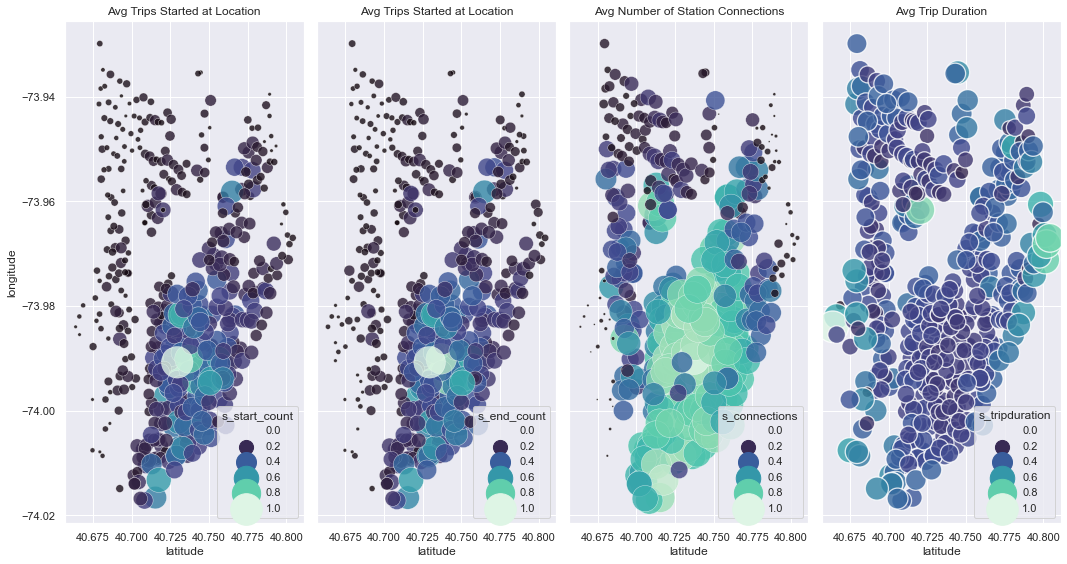

In [241]:
fig, ax = plt.subplots(1,4,figsize=(15,8))
sns.scatterplot(data=df, x="latitude", y="longitude", hue="s_start_count", size="s_start_count", 
                ax=ax[0], sizes=(0, 1000),palette="mako", alpha=0.8)

sns.scatterplot(data=df, x="latitude", y="longitude", hue="s_end_count", size="s_end_count", 
                ax=ax[1], sizes=(0, 1000),palette="mako", alpha=0.8)

sns.scatterplot(data=df, x="latitude", y="longitude", hue="s_connections", size="s_connections", 
                ax=ax[2], sizes=(0, 1000),palette="mako", alpha=0.8)

sns.scatterplot(data=df, x="latitude", y="longitude", hue="s_tripduration", size="s_tripduration", 
                ax=ax[3], sizes=(0, 1000),palette="mako", alpha=0.8)

ax[0].set_title("Avg Trips Started at Location")
ax[1].set_title("Avg Trips Started at Location")
ax[2].set_title("Avg Number of Station Connections")
ax[3].set_title("Avg Trip Duration")

ax[1].set_ylabel("")
ax[1].set_yticklabels([])

ax[2].set_ylabel("")
ax[2].set_yticklabels([])

ax[3].set_ylabel("")
ax[3].set_yticklabels([])

fig.tight_layout()

fig.savefig('images/individual_performances_map.png')

In [234]:
df['perf_score'] = df[['s_start_count', 's_end_count', 's_tripduration', 's_connections']].mean(axis=1)


In [240]:
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",color ='perf_score',
                        size ='perf_score',
                        zoom=10,width=800, height=400, opacity=0.5,color_continuous_scale=px.colors.sequential.Viridis,
                        range_color=[0,0.9],
                        hover_data=['start_count', 'end_count', 'tripduration', 'connections']
                        # zoom=3, height=300
                        )
fig.update_layout(mapbox_style="stamen-terrain", title="Custom Performance Map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()